In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


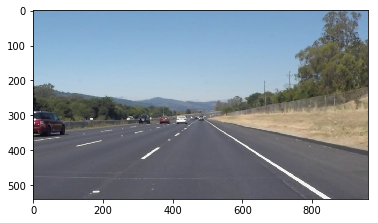

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image) 

# Helper functions

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    
    for line in lines:
        x1 = line[0]
        y1 = line[1]
        x2 = line[2]
        y2 = line[3]
        cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, Limg, Rimg, rho, theta, threshold, min_line_len, max_line_gap):
    """
    Returns an image with hough lines drawn.
    *Modified to do averaging to find final line predictions.
    """
    Llines = cv2.HoughLinesP(Limg, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    Rlines = cv2.HoughLinesP(Rimg, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
  
    it = 0
    Stotal = 0
    Xtotal = 0
    for line in Llines:  # Find the average slope of the left lane line, and the average x at y=400.
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > -0.90 and slope < -0.50:
                Stotal += slope
                it +=1
                Xtotal += x1+((400-y1)/slope)
    LeftAverageSlope = Stotal/it
    LeftAverageX = Xtotal/it
    
    it = 0
    stotal = 0
    xtotal = 0
    for line in Rlines:  # Find the average slope of the right lane line, and the average x at y=400.
        for x1,y1,x2,y2 in line:
            slope = (y2-y1)/(x2-x1)
            if slope > 0.50 and slope < 0.90:
                stotal += slope
                it +=1
                xtotal += x1+((400-y1)/slope)
    RightAverageSlope = stotal/it
    RightAverageX = xtotal/it
# Plot lines from the average (x,400) point along the slope to the horizon and the bottom of the picture
    LeftLaneLine = [int(LeftAverageX+((325-400)/LeftAverageSlope)), 325, int(LeftAverageX+((540-400)/LeftAverageSlope)), 540]
    RightLaneLine = [int(RightAverageX+((325-400)/RightAverageSlope)), 325, int(RightAverageX+((540-400)/RightAverageSlope)), 540]
    lane_lines = [LeftLaneLine, RightLaneLine]
    
    draw_lines(line_img, lane_lines)
    return line_img

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    Overlays the lines on the original image.
    `img` is the output of the hough_lines(), A blank image with lines drawn on it.
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

Test images

In [4]:
import os
os.listdir("test_images/")

['solidWhiteRight.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowCurve.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowLeft.jpg']

# Pipeline

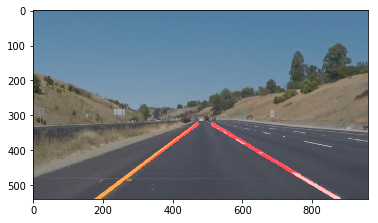

In [6]:
rho = 1
theta = np.pi/180
threshold = 3
min_line_len = 18
max_line_gap = 3

def pipeline(initial_img):
    imshape = initial_img.shape                     # define areas of interest for left and right lane lines
    Lvertices = np.array([[(0,imshape[0]),(450, 325), (500, 325), (490,imshape[0])]], dtype=np.int32)
    Rvertices = np.array([[(490,imshape[0]),(485, 325), (515, 325), (imshape[1],imshape[0])]], dtype=np.int32)
    image = grayscale(np.copy(initial_img))
    image = gaussian_blur(image, 5)
    image = canny(image, 75, 150)
    left = region_of_interest(np.copy(image), Lvertices)
    right = region_of_interest(np.copy(image), Rvertices)
    image = hough_lines(image, left, right, rho, theta, threshold, min_line_len, max_line_gap)
    final = weighted_img(image, initial_img, α=0.8, β=1., γ=0.)
    return final

plt.imshow(pipeline(mpimg.imread('test_images/whiteCarLaneSwitch.jpg')))

## Videos

In [7]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [9]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:05<00:00, 39.75it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.06 s, sys: 232 ms, total: 3.3 s
Wall time: 6.4 s


In [10]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [11]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(pipeline)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:18<00:00, 36.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.81 s, sys: 544 ms, total: 10.4 s
Wall time: 19.4 s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))